# Notebook to run tests before deployment.

Run this before deployments!

The following functionalities are tested:
1. Find download links for certain regions.
2. Cropping satellite images.
3. Adding new bands: NDVI, re_ndvi, NDWI.
4. Cloud detection.

If error occur be sure to delete to unzip folder, which could lead to more errors!

In [1]:
import satellite_images_nso.api.nso_georegion as nso
from settings import nso_username, nso_password, path_geojson, output_path, path_test_input_data
import os
# Optional
from settings import height_band_filepath, cloud_detection_model_path, links_must_contain
import rasterio
from rasterio.plot import show
import satellite_images_nso._manipulation.nso_manipulator as nso_manipulator
import matplotlib.pyplot as plt
# the cloud_recognition.api needs to be imported from the natura2000 data science repo
from cloud_recognition.api import detect_clouds
import pickle
import numpy as np
import requests
import glob
import os

In [7]:
def plot_nso_tif(filepath):
    """
    
    Plots .tif files

    @param filepath: the filepath to a region
    """

    src = rasterio.open(filepath)
    plot_out_image = (
            np.clip(src.read()[2::-1], 0, 2200) / 2200
        )  # out_image[2::-1] selects the first three items, reversed

    plt.figure(figsize=(10, 10))
    rasterio.plot.show(plot_out_image, transform=src.transform)
    src.close()


def all_true(arr):
    for val in arr:
        if not val:
            return False
    return True

def all_false(arr):
    for val in arr:
        if val:
            return False
    return True


def download_zip(url):
    # URL of the zip file you want to download
    zip_url = url

    # Local path where you want to save the downloaded zip file
    local_tiff_path = output_path+"/"+url.split("/")[-1]

    # Send a GET request to the URL to download the zip file
    response = requests.get(zip_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Write the content of the response (the zip file) to a local file
        with open(local_tiff_path, "wb") as file:
            file.write(response.content)
        
        print(f"zip file has been downloaded to {local_tiff_path}")
    else:
        print("Failed to download zip file:", response.status_code)

In [5]:
# Download test data if it does not exist.
if not os.path.exists(output_path+"/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO.zip"):
    download_zip("https://e34a505986aa74678a5a0e0f.blob.core.windows.net/satellite-images-nso/Test_regions/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO.zip")

if not os.path.exists(output_path+"/20191202_110523_SV1-04_SV_RD_11bit_RGBI_50cm.zip"):
    download_zip("https://e34a505986aa74678a5a0e0f.blob.core.windows.net/satellite-images-nso/Test_regions/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO.zip")

True

# Link tests

In [8]:
georegion = nso.nso_georegion(
    path_to_geojson= path_geojson, 
    output_folder= output_path,
    username=nso_username,
    password=nso_password,
    )

Multipolygon detected!
Buffering to grow the different multipolygons together in one polygon for retrieving links


In [9]:
# Test if links are found
links = georegion.retrieve_download_links(max_diff=0.5, start_date="2011-01-01")

assert len(links) >0, "No links found error!"

# Columns to check for existence
columns_to_check = ['link', 'percentage_geojson', 'missing_polygon', 'covered_polygon']

# Check if columns exist
existing_columns = [col for col in columns_to_check if col in links.columns]

assert len(existing_columns) == len(columns_to_check), "Certain columns are not in the links"

Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.41549528  4.41926775  4.41723445  4.41318064  4.41549528]
 [52.2294102  52.22758151 52.22497275 52.22687817 52.2294102 ]]
Passed region check
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.41549528  4.41926775  4.41723445  4.41318064  4.41549528]
 [52.2294102  52.22758151 52.22497275 52.22687817 52.2294102 ]]
Passed region check
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.41549528  4.41926775  4.41723445  4.41318064  4.41549528]
 [52.2294102  52.22758151 52.22497275 52.22687817 52.2294102 ]]
Passed region check
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.41549528  4.41926775  4.41723445  4.41318064  4.41549528]
 [52.2294102  52.22758151 52.22497275 52.22687817 52.2294102 ]]
Passed region check
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff i

## PNEO link test

In [7]:
# Test if PNEO links are found
pneo_links = links[links['resolution'] == "30cm"]
pneo_links = pneo_links[pneo_links["link"].str.contains("RGBNED")]
pneo_links = pneo_links.sort_values("percentage_geojson")


assert len(pneo_links) >0, "No PNEO links found error!"

## Superview  link test

In [10]:
# Example filter on resolution and bands
superview_links = links[links['resolution'] == "50cm"]
superview_links = superview_links[superview_links["link"].str.contains("RGBI")]
superview_links = superview_links.sort_values("percentage_geojson")

assert len(superview_links) >0, "No  PNEO links found error!"

# Cropping Tests

## PNEO cropping tests - Polygon

Multipolygon detected!
Buffering to grow the different multipolygons together in one polygon for retrieving links
Searching for: E:/data/test\20230513_104139_PNEO-03_1_1**Test_region*cropped*.tif
No Found files
Zip file found skipping download
Extracting files
Extracted folder is: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO
cropping file E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped.tif
New cropped filename: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif
Cropping multipolygons
raster path opened
Assuming PNEO Satellite columns
convert to RD
Plotting data for:E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_1

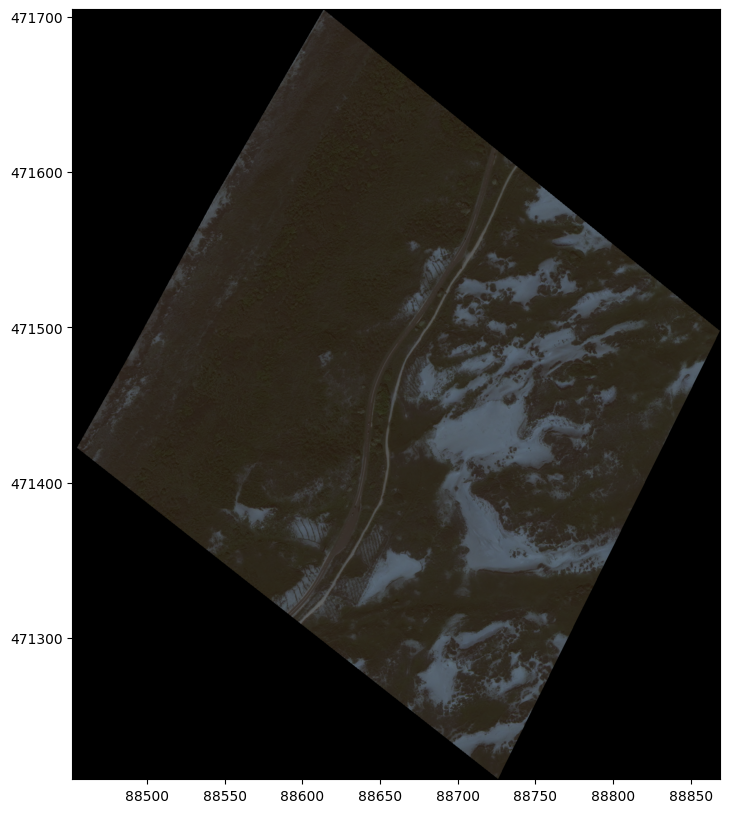

finished cropping E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped.tif
Cropped file is found at: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif
Succesfully cropped .tif file
E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif is Ready


In [9]:
georegion = nso.nso_georegion(
    path_to_geojson= path_test_input_data+"Test_region.geojson",
    output_folder= output_path,
    username=nso_username,
    password=nso_password,
    )


filepath = georegion.execute_link("https://api.satellietdataportaal.nl/v1/download/30cm_RGBNED_12bit_PNEO/20230513_104139_PNEO-03_1_1")

assert filepath, "No file has been downloaded or extracted for a polygon in PNEO!"

# Remove the file for later tests
os.remove(filepath)

## PNEO cropping tests - MultiPolygon

Multipolygon detected!
Buffering to grow the different multipolygons together in one polygon for retrieving links
Searching for: E:/data/test\20230513_104139_PNEO-03_1_1**Test_multipolygon_region*cropped*.tif
No Found files
Zip file found skipping download
Extracting files
Extracted folder is: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO
cropping file E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped.tif
New cropped filename: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_multipolygon_region_cropped.tif
Cropping multipolygons
raster path opened
Assuming PNEO Satellite columns
convert to RD
Plotting data for:E:/data/test/20230513_104139

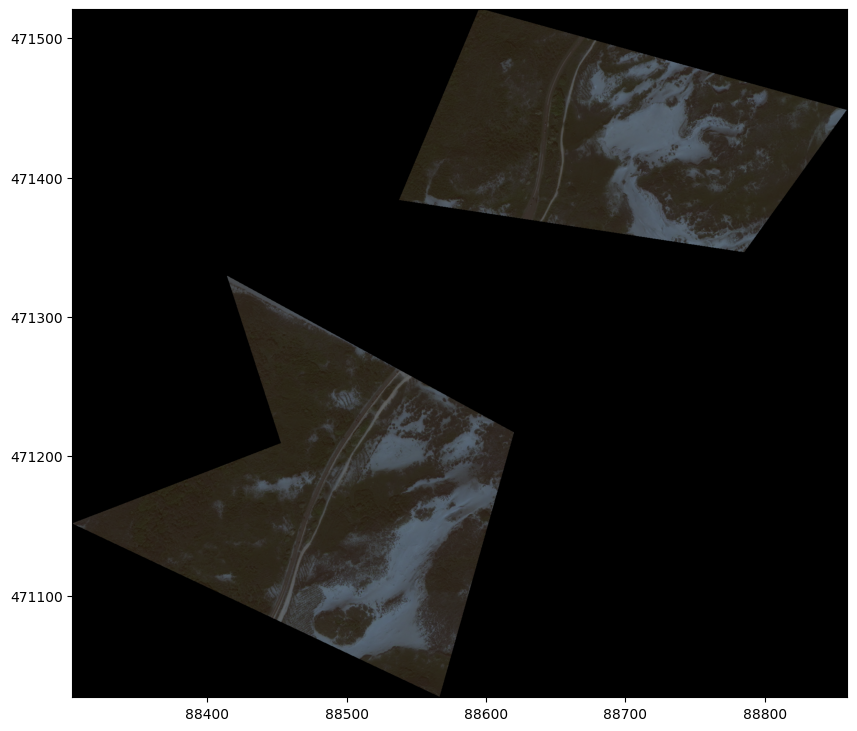

finished cropping E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped.tif
Cropped file is found at: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_multipolygon_region_cropped.tif
Succesfully cropped .tif file
E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_multipolygon_region_cropped.tif is Ready


In [10]:
georegion = nso.nso_georegion(
    path_to_geojson= path_test_input_data+"Test_multipolygon_region.geojson",
    output_folder= output_path,
    username=nso_username,
    password=nso_password,
    )


filepath = georegion.execute_link("https://api.satellietdataportaal.nl/v1/download/30cm_RGBNED_12bit_PNEO/20230513_104139_PNEO-03_1_1")

assert filepath, "No file has been downloaded or extracted for multiPolygons"

# Remove the file for later tests
os.remove(filepath)

# Adding re_ndvi, ndvi, ndwi channels on PNEO tests

### Adding re_ndvi, ndwi to PNEO satellite images

Multipolygon detected!
Buffering to grow the different multipolygons together in one polygon for retrieving links
Searching for: E:/data/test\20230513_104139_PNEO-03_1_1**Test_region*cropped*.tif
No Found files
Zip file found skipping download
Extracting files
Extracted folder is: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO
cropping file E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped.tif
New cropped filename: E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_12bit_PNEO\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee\20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif
Cropping multipolygons
raster path opened
Assuming PNEO Satellite columns
convert to RD
finished cropping E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RGBNED_1

c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:58: RuntimeWarning: invalid value encountered in divide
  re_ndvi = (red_edge - red) / (red_edge + red) * 100 + 100


Done with calculating re_ndvi channel
Saving to E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped_re_ndvi.tif
Number of bands: 7


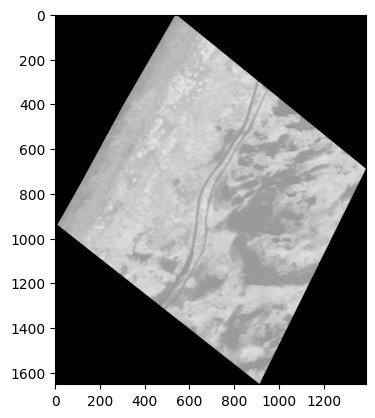

In [2]:
# Test re_ndvi on PNEO coepelduynen and see if gives the best results.
path_geojson = path_test_input_data+"Test_region.geojson"

georegion = nso.nso_georegion(
    path_to_geojson=path_geojson, 
    output_folder=output_path,
    username=nso_username,
    password=nso_password,
    )

filepath = georegion.execute_link("https://api.satellietdataportaal.nl/v1/download/30cm_RGBNED_12bit_PNEO/20230513_104139_PNEO-03_1_1", add_red_edge_ndvi_band= True, plot = False)

# Open the TIFF image and display ndvi
with rasterio.open(filepath) as src:
    # Get the number of bands
    num_bands = src.count
    print("Number of bands:", num_bands)

    assert num_bands >= 7, "re_ndvi bands not added correctly"
    
    # Read one of the bands (e.g., the first band)
    band = src.read(num_bands)  # Change the index to plot a different band
    show(band, cmap='gray')  # Adjust the colormap as needed

In [ ]:
os.remove(filepath)

Generating NDWI channel...


c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:75: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - near_infra_red) / (near_infra_red + green) * 100 + 100


Done with calculating ndwi channel
Saving to E:/data/test/20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped_re_ndvi_ndwi.tif
Number of bands: 8


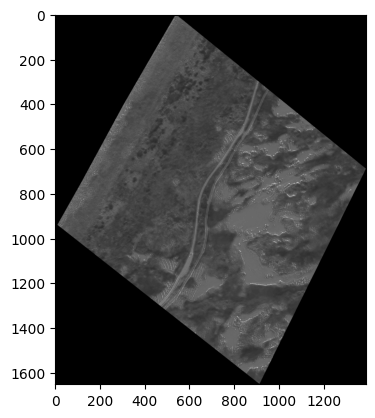

In [3]:
# Test re_ndvi on PNEO coepelduynen and see if gives the best results.
path_geojson = path_test_input_data+"Test_region.geojson"

georegion = nso.nso_georegion(
    path_to_geojson=path_geojson, 
    output_folder=output_path,
    username=nso_username,
    password=nso_password,
    )

filepath = georegion.execute_link("https://api.satellietdataportaal.nl/v1/download/30cm_RGBNED_12bit_PNEO/20230513_104139_PNEO-03_1_1", add_red_edge_ndvi_band= True, plot = False)

# Add a additional the NDWI Channel
filepath_ndwi = nso_manipulator.add_index_channels(filepath, ["ndwi"])


# Open the TIFF image and display ndvi
with rasterio.open(filepath_ndwi) as src:
    # Get the number of bands
    num_bands = src.count
    print("Number of bands:", num_bands)

    assert num_bands >= 8, "ndwi bands not added correctly"
    
    # Read one of the bands (e.g., the first band)
    band = src.read(num_bands)  # Change the index to plot a different band
    show(band, cmap='gray')  # Adjust the colormap as needed

In [4]:
# Remove them for further tests
os.remove(filepath)
os.remove(filepath_ndwi)

# Check ndvi Superview

Searching for: E:/data/test\20191202_110523_SV1-04**Test_region*cropped*.tif
No Found files
Zip file found skipping download
Extracting files
Extracted folder is: E:/data/test/20191202_110523_SV1-04_SV_RD_11bit_RGBI_50cm
cropping file E:/data/test/20191202_110523_SV1-04_SV_RD_11bit_RGBI_50cm\20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped.tif
New cropped filename: E:/data/test/20191202_110523_SV1-04_SV_RD_11bit_RGBI_50cm\20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif
Cropping multipolygons
raster path opened
Assuming Superview Satellite columns
convert to RD
Plotting data for:E:/data/test/20191202_110523_SV1-04_SV_RD_11bit_RGBI_50cm\20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif-----------------------------------------------------


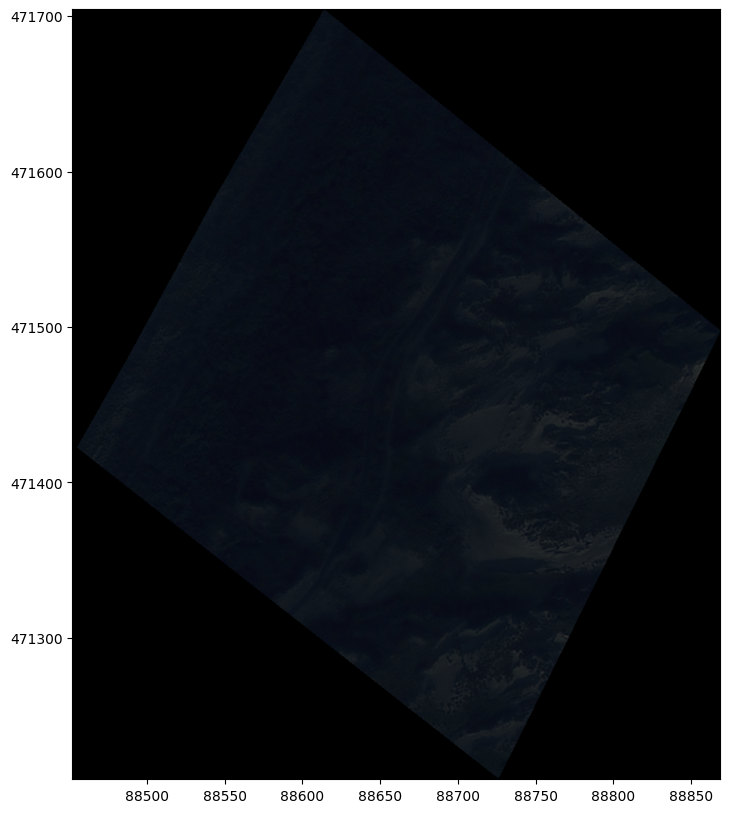

finished cropping E:/data/test/20191202_110523_SV1-04_SV_RD_11bit_RGBI_50cm\20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped.tif
Cropped file is found at: E:/data/test/20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif
Succesfully cropped .tif file
E:/data/test/20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped.tif is Ready
Generating NDVI channel...
Done with calculating ndvi channel
Saving to E:/data/test/20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped_ndvi.tif


c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:41: RuntimeWarning: invalid value encountered in divide
  ndvi = (near_infra_red - red) / (near_infra_red + red) * 100 + 100


In [16]:
# Test re_ndvi on PNEO coepelduynen and see if gives the best results.
path_geojson = path_test_input_data+"Test_region.geojson"

georegion = nso.nso_georegion(
    path_to_geojson=path_geojson, 
    output_folder=output_path,
    username=nso_username,
    password=nso_password,
    )

filepath = georegion.execute_link("https://api.satellietdataportaal.nl/v1/download/SV_RD_11bit_RGBI_50cm/20191202_110523_SV1-04", add_ndvi_band= True, plot=False)

Number of bands: 5


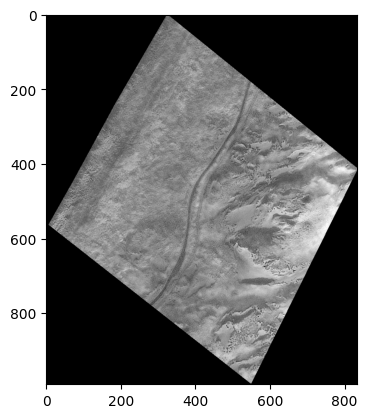

In [17]:
# Open the TIFF image and display ndvi
with rasterio.open(filepath) as src:
        # Get the number of bands
        num_bands = src.count
        print("Number of bands:", num_bands)

        assert num_bands >= 5, "ndvi bands not added correctly"
        
        # Read one of the bands (e.g., the first band)
        band = src.read(num_bands)  # Change the index to plot a different band
        show(band, cmap='gray')

In [ ]:
os.remove(filepath)

Generating NDWI channel...


c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:75: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - near_infra_red) / (near_infra_red + green) * 100 + 100


Done with calculating ndwi channel
Saving to E:/data/test/20191202_110523_SV1-04_50cm_RD_11bit_RGBI_NoordwijkAanZee_Coepelduynen_cropped_Test_region_cropped_ndvi_ndwi.tif
Number of bands: 6


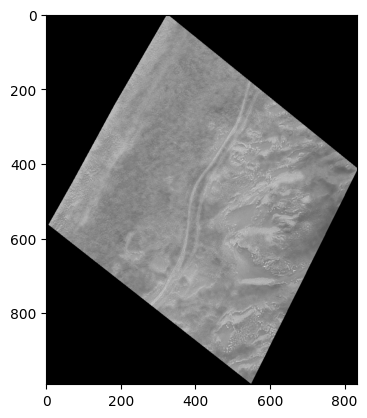

In [18]:
# Test re_ndvi on PNEO coepelduynen and see if gives the best results.
path_geojson = path_test_input_data+"Test_region.geojson"

georegion = nso.nso_georegion(
    path_to_geojson=path_geojson, 
    output_folder=output_path,
    username=nso_username,
    password=nso_password,
    )

filepath = georegion.execute_link("https://api.satellietdataportaal.nl/v1/download/SV_RD_11bit_RGBI_50cm/20191202_110523_SV1-04", add_ndvi_band= True, plot=False)

# Add the NDWI Channel
filepath_ndwi = nso_manipulator.add_index_channels(filepath, ["ndwi"])


# Open the TIFF image and display ndvi
with rasterio.open(filepath_ndwi) as src:
    # Get the number of bands
    num_bands = src.count
    print("Number of bands:", num_bands)

    assert num_bands >= 6, "re_ndvi bands not added correctly"
    
    # Read one of the bands (e.g., the first band)
    band = src.read(num_bands)  # Change the index to plot a different band
    show(band, cmap='gray')  # Adjust the colormap as needed

In [19]:
# Remove them for further tests
os.remove(filepath)
os.remove(filepath_ndwi)

# Cloud detection tests

In [20]:
path_to_model = pickle.load(open("C:/repos/satellite-images-nso/models/cloud_detection_logistic_regression_v1.0.sav", "rb"))

c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 

In [21]:
cloud_pictures = ["E:/data/coepelduynen/20220514_114854_SV1-02_SV_RD_11bit_RGBI_50cm_Rijnsburg_natura2000_coepelduynen_cropped.tif","E:/data/coepelduynen/20190302_105829_SV1-01_50cm_RD_11bit_RGBI_KatwijkAanZee_natura2000_coepelduynen_cropped.tif", "E:/data/coepelduynen/20191202_110525_SV1-04_50cm_RD_11bit_RGBI_KatwijkAanZee_natura2000_coepelduynen_cropped.tif" ]

In [22]:
#for tif_file in cloud_pictures:
#    print("------")
#   print(tif_file)
#    plot_nso_tif(tif_file)

------
E:/data/coepelduynen/20220514_114854_SV1-02_SV_RD_11bit_RGBI_50cm_Rijnsburg_natura2000_coepelduynen_cropped.tif


KeyboardInterrupt: 

In [23]:
non_cloud_pictures = ["E:/data/coepelduynen/20230402_105321_PNEO-03_1_49_30cm_RD_12bit_RGBNED_Zoeterwoude_natura2000_coepelduynen_cropped.tif", "E:/data/coepelduynen/20230513_104139_PNEO-03_1_1_30cm_RD_12bit_RGBNED_NoordwijkAanZee_natura2000_coepelduynen_cropped.tif", "E:/data/coepelduynen/20220515_113347_SV1-02_SV_RD_11bit_RGBI_50cm_KatwijkAanZee_natura2000_coepelduynen_cropped.tif"]

In [24]:
#for tif_file in non_cloud_pictures:
#    print("------")
#    print(tif_file)
#    plot_nso_tif(tif_file)

In [25]:
positive_pictures = [detect_clouds(model=path_to_model,filepath=afile) for afile in cloud_pictures]
false_pictures = [detect_clouds(model=path_to_model,filepath=afile) for afile in non_cloud_pictures]

In [26]:
assert all_true(positive_pictures), "Not all values are True"

assert all_false(false_pictures), " Not all values are False"